In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp
from jax import random
from jax.scipy.stats import norm

from jax_sgmc import data, potential, scheduler, adaption, integrator, solver, io
from jax_sgmc.data.numpy_loader import NumpyDataLoader
from jax_sgmc.data.hdf5_loader import HDF5Loader

/home/student/ana/venv38/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Setup Custom Solver

This example shows how to customize a solver by combining the individual
modules of **JaxSGMC**.
It covers all necessary steps to build a *SGLD* solver with *RMSprop* adaption
and applies it to the same problem as described in {doc}`/quickstart/`.

## Overview

Schematically, a solver in **JaxSGMC** has the structure:

![Structure of JaxSGMC](../../jax-sgmc-structure.svg)

The SGLD solver with RMSprop adaption will make use of all modules.
It is set up in these steps:

- **[Load Reference Data](#load-reference-data)**
- **[Transform Log-likelihood to Potential](#transform-log-likelihood-to-potential)**
- **[RMSprop Adaption](#rmsprop-adaption)**
- **[Integrator and Solver](#integrator-and-solver)**
- **[Scheduler](#scheduler)**
- **[Save Samples](#save-samples-in-numpy-arrays)**
- **[Run Solver](#run-solver)**

## Load Reference Data

The reference data is passed to the solver via two components, the Data Loader
and the Host Callback Wrapper.

The Data Loader assembles the batches requested by the host callback wrappers.
It loads the data from a source (HDF-File, numpy-array, tensorflow dataset)
and selects the observations in each batch after a specific method
(ordered access, shuffling, ...).

The Host Callback Wrapper requests new batches from the Data Loader and loads
them into jit-compiled programs via Jax's Host Callback module.
To balance the memory usage and the delay due to loading the data, each device
call returns multiple batches.

In [2]:
N = 4 
samples = 1000 # Total samples

key = random.PRNGKey(0)
split1, split2, split3 = random.split(key, 3)

# Correct solution
sigma = 0.5
w = random.uniform(split3, minval=-1, maxval=1, shape=(N, 1))

# Data generation
noise = sigma * random.normal(split2, shape=(samples, 1))
x = random.uniform(split1, minval=-10, maxval=10, shape=(samples, N))
training_data_x  = jnp.stack([x[:, 0] + x[:, 1], x[:, 1], 0.1 * x[:, 2] - 0.5 * x[:, 3],
               x[:, 3]]).transpose()
training_data_y = jnp.matmul(training_data_x, w) + noise

The NumpyDataLoader assembles batches randomly by drawing from the the complete
dataset with and without replacement (shuffeling).
It also provides the possibility to start the batching from a defined state, 
controlled via the seed.

These settings can be passed differently for every chain and are thus not passed
during the initialization.
Instead, they have to be passed during the
[initialization of the chains](#integrator-and-solver).

In this example, the batches are shuffled, i.e. every sample is used at least
once before an already drawn sample is used again and the chains start at a
defined state.

In [3]:
# The construction of the data loader can be different. For the numpy data
# loader, the numpy arrays can be passed as keyword arguments and are later
# returned as a dictionary with corresponding keys.
data_loader = NumpyDataLoader(x=training_data_x, y=training_data_y)

# The cache size corresponds to the number of batches per cache. The state
# initialized via the init function is necessary to identify which data chain
# request new batches of data.
data_fn = data.random_reference_data(data_loader, mb_size=N, cached_batches_count=100)

data_loader_kwargs = {
    "seed": 0,
    "shuffle": True,
    "in_epochs": False
}

## Transform Log-likelihood to Potential

The model is connected to the solver via the (log-)prior and (log-)likelihood
function. The model for our problem is:

In [4]:
def model(sample, observations):
    weights = sample["w"]
    predictors = observations["x"]
    return jnp.dot(predictors, weights)

**JaxSGMC** supports samples in the form of pytrees, so no flattering of e.g.
Neural Net parameters is necessary. In our case we can separate the standard
deviation, which is only part of the likelihood, from the weights by using a
dictionary:

In [5]:
def log_likelihood(sample, observations):
    sigma = jnp.exp(sample["log_sigma"])
    y = observations["y"]
    y_pred = model(sample, observations)
    return norm.logpdf(y - y_pred, loc=0, scale=sigma)

def log_prior(sample):
    return 1 / jnp.exp(sample["log_sigma"])
    

The prior and likelihood are not passed to the solver directly, but 
first transformed into a (stochastic) potential.
This allows us to formulate the model and so the likelihood with only a single 
observation in mind and let **JaxSGMC** take care of evaluating it for a batch
of observations. As the model is not computationally demanding, we let 
**JaxSGMC** vectorize the evaluation of the likelihood:

In [6]:
potential_fn = potential.minibatch_potential(prior=log_prior,
                                             likelihood=log_likelihood)

## RMSprop Adaption

The adaption module simplifies the implementation of an adaption strategy
by raveling / unraveling the latent variables pytree.

The RMSprop adaption is characterized by two parameters, which can be set
dynamically for each chain.
As for the data loader arguments, non-default RMSprop parameters must be passed
during the [initialization of the chains](#integrator-and-solver).

In [7]:
rms_prop_adaption = adaption.rms_prop()

adaption_kwargs = {
    "lmbd": 1e-6,
    "alpha": 0.99
}

## Integrator and Solver

The integrator proposes new samples based on a specific process which are then
processed by the solver.
For example, the solver might reject a proposal by a Metropolis Hastings
acceptance step (AMAGOLD, SGGMC) or swap it with another proposal by a parallel
tempering chain swap (reSGLD).

In this case, a Langevin Diffusion process proposes a new sample, which is
accepted unconditionally by the solver.

After this step we defined our process.
Therefore, we can now initialize the starting states of each chain with the
dynamic settings for the data loader and adaption.

In [8]:
ld_integrator = integrator.langevin_diffusion(potential_fn=potential_fn,
                                                   batch_fn=data_fn,
                                                   adaption=rms_prop_adaption)

# Returns a triplet of init_fn, update_fn and get_fn
rms_prop_solver = solver.sgmc(ld_integrator)

# Initialize the solver by providing initial values for the latent variables.
# We provide extra arguments for the data loader and the adaption method.
init_sample = {"log_sigma": jnp.array(0.0), "w": jnp.zeros(N)}
init_state = rms_prop_solver[0](init_sample)
                                # adaption_kwargs=adaption_kwargs,
                                # batch_kwargs=data_loader_kwargs)

## Scheduler

Next, we set up a schedule which updates process parameters such as the
temperature and the step size independently of the solver state.
It is moreover necessary to determine which samples should be saved or discarded.

SGLD only depends on the step size, which is chosen to follow a polynomial
schedule.
However, as only a few and independent samples should be saved, we also set up a
burn in schedule, which rejects the first 2000 samples and a thinning schedule,
which randomly selects 1000 samples not subject to burn in.

In [9]:
step_size_schedule = scheduler.polynomial_step_size_first_last(first=0.05,
                                                               last=0.001,
                                                               gamma=0.33)
burn_in_schedule = scheduler.initial_burn_in(2000)
thinning_schedule = scheduler.random_thinning(step_size_schedule=step_size_schedule,
                                              burn_in_schedule=burn_in_schedule,
                                              selections=1000)

# Bundles all specific schedules
schedule = scheduler.init_scheduler(step_size=step_size_schedule,
                                    burn_in=burn_in_schedule,
                                    thinning=thinning_schedule)

## Save samples in numpy Arrays

By default, **JaxSGMC** save accepted samples in the device memory.
However, for some models the required memory rapidly exceeds the available 
memory. Therefore, **JaxSGMC** supports saving the samples on the host in a
similar manner as it loads reference data from the host.

Hence, also the saving step consists of setting up a Data Collector, which takes
care of saving the data in different formats and a general Host Callback Wrapper
which transfers the data out of jit-compiled computations.

In this example, the data is simply passed to (real) numpy arrays in the host
memory.

In [10]:
data_collector = io.MemoryCollector()
save_fn = io.save(data_collector=data_collector)

## Run Solver

Finally, all parts of the solver are set up and can be combined to a runnable
process.
The mcmc function updates the scheduler and integrator in the correct order and
passes the results to the saving module. 

The mcmc function can be called with multiple ``init_states`` as
positional arguments to run multiple chains and returns a list of results, one
for each chain.

In [11]:
mcmc = solver.mcmc(solver=rms_prop_solver,
                   scheduler=schedule,
                   saving=save_fn)

# Take the result of the first chain
results = mcmc(init_state, iterations=10000)[0]


print(f"Collected {results['sample_count']} samples")

/home/student/ana/jax-sgmc/jax_sgmc/integrator.py:130: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, tree_def = tree_flatten(a)
/home/student/ana/jax-sgmc/jax_sgmc/integrator.py:134: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  noise_tree = tree_unflatten(tree_def, noise_leaves)
/home/student/ana/venv38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


[Step 0/10000](0%) Collected 0 of 1000 samples...
[Step 500/10000](5%) Collected 0 of 1000 samples...
[Step 1000/10000](10%) Collected 0 of 1000 samples...
[Step 1500/10000](15%) Collected 0 of 1000 samples...
[Step 2000/10000](20%) Collected 1 of 1000 samples...
[Step 2500/10000](25%) Collected 87 of 1000 samples...
[Step 3000/10000](30%) Collected 168 of 1000 samples...
[Step 3500/10000](35%) Collected 245 of 1000 samples...
[Step 4000/10000](40%) Collected 315 of 1000 samples...
[Step 4500/10000](45%) Collected 374 of 1000 samples...
[Step 5000/10000](50%) Collected 437 of 1000 samples...
[Step 5500/10000](55%) Collected 496 of 1000 samples...
[Step 6000/10000](60%) Collected 551 of 1000 samples...
[Step 6500/10000](65%) Collected 613 of 1000 samples...
[Step 7000/10000](70%) Collected 682 of 1000 samples...
[Step 7500/10000](75%) Collected 736 of 1000 samples...
[Step 8000/10000](80%) Collected 787 of 1000 samples...
[Step 8500/10000](85%) Collected 839 of 1000 samples...
[Step 900

## Numpyro Model

In [14]:
from numpyro import sample as npy_smpl
import numpyro.infer as npy_inf
import numpyro.distributions as npy_dist

def numpyro_model(y_obs=None):
  sigma = npy_smpl("sigma", npy_dist.Uniform(low=0.0, high=10.0))
  weights = npy_smpl("weights",
                     npy_dist.Uniform(low=-10 * jnp.ones((N, 1)),
                                      high=10 * jnp.ones((N, 1))))

  y_pred = jnp.matmul(training_data_x, weights)
  npy_smpl("likelihood", npy_dist.Normal(loc=y_pred, scale=sigma), obs=y_obs)

# Collect 1000 samples

kernel = npy_inf.HMC(numpyro_model)
mcmc = npy_inf.MCMC(kernel, num_warmup=1000, num_samples=1000, progress_bar=False)
mcmc.run(random.PRNGKey(0), y_obs=training_data_y)
mcmc.print_summary()

w_npy = mcmc.get_samples()["weights"]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       sigma      0.50      0.01      0.50      0.48      0.52    221.42      1.00
weights[0,0]      0.09      0.00      0.09      0.09      0.10   1769.78      1.00
weights[1,0]     -0.49      0.00     -0.49     -0.50     -0.48   5434.48      1.00
weights[2,0]     -0.18      0.03     -0.18     -0.23     -0.14    240.88      1.00
weights[3,0]     -0.65      0.01     -0.65     -0.67     -0.62    239.81      1.00

Number of divergences: 0


## Plot Results

/tmp/ipykernel_121958/1568358948.py:32: UserWarning: The following kwargs were not used by contour: 'label'
  ax2.contour(W1d, W2d, Z12d, levels, colors='red', linewidths=0.5, label="HMC")


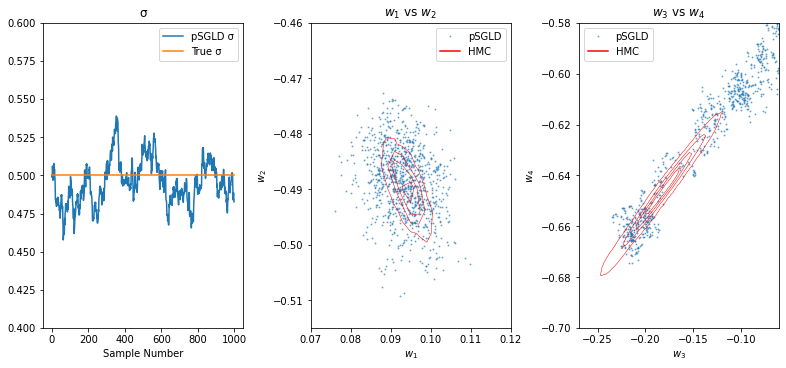

In [15]:

sigma_rms = onp.exp(results["samples"]["variables"]["log_sigma"])
w_rms = results["samples"]["variables"]["w"]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10.8, 5))

ax1.set_title("σ")
ax1.plot(sigma_rms, label="pSGLD σ")
ax1.plot([sigma]*onp.shape(sigma_rms)[0], label="True σ")
ax1.set_xlabel("Sample Number")
ax1.set_ylim([0.4, 0.6])
ax1.legend()

# Contours of numpyro solution
levels = onp.linspace(0.1, 1.0, 5)

from scipy.stats import gaussian_kde

# w1 vs w2
w12 = gaussian_kde(jnp.squeeze(w_npy[:, 0:2].transpose()))
w1d = onp.linspace(0.00, 0.20, 100)
w2d = onp.linspace(-0.70, -0.30, 100)
W1d, W2d = onp.meshgrid(w1d, w2d)
p12d = onp.vstack([W1d.ravel(), W2d.ravel()])
Z12d = onp.reshape(w12(p12d).T, W1d.shape)
Z12d /= Z12d.max()

ax2.set_xlabel("$w_1$")
ax2.set_ylabel("$w_2$")
ax2.set_title("$w_1$ vs $w_2$")
ax2.set_xlim([0.07, 0.12])
ax2.set_ylim([-0.515, -0.46])
ax2.contour(W1d, W2d, Z12d, levels, colors='red', linewidths=0.5, label="HMC")
ax2.plot(w_rms[:, 0], w_rms[:, 1], 'o', alpha=0.5, markersize=1, zorder=-1, label="pSGLD")
ax2.plot([1],[2], color='red', label="HMC") # adding this just to make contour plot visible in legend, not visualizing anything
ax2.legend()

# w3 vs w4
w34 = gaussian_kde(jnp.squeeze(w_npy[:, 2:4].transpose()))
w3d = onp.linspace(-0.3, -0.05, 100)
w4d = onp.linspace(-0.75, -0.575, 100)
W3d, W4d = onp.meshgrid(w3d, w4d)
p34d = onp.vstack([W3d.ravel(), W4d.ravel()])
Z34d = onp.reshape(w34(p34d).T, W3d.shape)
Z34d /= Z34d.max()

ax3.set_xlabel("$w_3$")
ax3.set_ylabel("$w_4$")
ax3.set_title("$w_3$ vs $w_4$")
ax3.set_xlim([-0.27, -0.06])
ax3.set_ylim([-0.70, -0.58])
ax3.plot(w_rms[:, 2], w_rms[:, 3], 'o', alpha=0.5, markersize=1, zorder=-1, label="pSGLD")
ax3.contour(W3d, W4d, Z34d, levels, colors='red', linewidths=0.5)
ax3.plot([1],[1], color='red', label="HMC")  # adding this just to make contour plot visible in legend, not visualizing anything
ax3.legend()
fig.tight_layout(pad=0.3)
plt.savefig("linear_regression_results.pdf", format="pdf")
plt.show()

## Large Models: Save Data to HDF5

In [16]:
# Open a HDF5 file to store data in
with h5py.File("sgld_rms.hdf5", "w") as file:

    data_collector = io.HDF5Collector(file)
    save_fn = io.save(data_collector=data_collector)

    mcmc = solver.mcmc(solver=rms_prop_solver,
                   scheduler=schedule,
                   saving=save_fn)

    # The solver has to be reinitialized, as the data loader has to be reinitialized
    init_state = rms_prop_solver[0](init_sample,
                                    adaption_kwargs=adaption_kwargs,
                                    batch_kwargs=data_loader_kwargs)
    results = mcmc(init_state, iterations=10000)[0]

print(f"Collected {results['sample_count']} samples")

/home/student/ana/jax-sgmc/jax_sgmc/integrator.py:130: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, tree_def = tree_flatten(a)
/home/student/ana/jax-sgmc/jax_sgmc/integrator.py:134: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  noise_tree = tree_unflatten(tree_def, noise_leaves)
/home/student/ana/venv38/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype int64 requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


[Step 0/10000](0%) Collected 0 of 1000 samples...
[Step 500/10000](5%) Collected 0 of 1000 samples...
[Step 1000/10000](10%) Collected 0 of 1000 samples...
[Step 1500/10000](15%) Collected 0 of 1000 samples...
[Step 2000/10000](20%) Collected 1 of 1000 samples...
[Step 2500/10000](25%) Collected 87 of 1000 samples...
[Step 3000/10000](30%) Collected 168 of 1000 samples...
[Step 3500/10000](35%) Collected 245 of 1000 samples...
[Step 4000/10000](40%) Collected 315 of 1000 samples...
[Step 4500/10000](45%) Collected 374 of 1000 samples...
[Step 5000/10000](50%) Collected 437 of 1000 samples...
[Step 5500/10000](55%) Collected 496 of 1000 samples...
[Step 6000/10000](60%) Collected 551 of 1000 samples...
[Step 6500/10000](65%) Collected 613 of 1000 samples...
[Step 7000/10000](70%) Collected 682 of 1000 samples...
[Step 7500/10000](75%) Collected 736 of 1000 samples...
[Step 8000/10000](80%) Collected 787 of 1000 samples...
[Step 8500/10000](85%) Collected 839 of 1000 samples...
[Step 900

In [ ]:
# Sum up and count all values
def map_fn(batch, mask, count):
    return jnp.sum(batch["w"].T * mask, axis=1), count + jnp.sum(mask)

# Load only the samples from the file
with h5py.File("sgld_rms.hdf5", "r") as file:
    postprocess_loader = HDF5Loader(file, subdir="/chain~0/variables", sample=init_sample)

    full_data_mapper, _ = data.full_data_mapper(postprocess_loader, 128, 128)
    w_sums, count = full_data_mapper(map_fn, 0, masking=True)

    # Sum up the sums from the individual batches
    w_means = jnp.sum(w_sums, axis=0) / count

print(f"Collected {count} samples with means:")
for idx, (w, w_old) in enumerate(zip(w_means, onp.mean(w_rms, axis=0))):
  print(f"  w_{idx}: new = {w}, old = {w_old})")

In [ ]:
import os
os.remove("sgld_rms.hdf5")